In [ ]:
import re
import nltk
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

warnings.filterwarnings("ignore")

sns.set(style='whitegrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Prepocess data

### Load data

In [ ]:
df = pd.read_csv('amazon.csv')
df.head(3)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...


### Analyze sales dataset

#### Get infomration about columns

In [ ]:
df.columns

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')

#### Get nformation about the structure and data types of the DataFrame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

### Handle datatypes conversion and claning the data

#### Deal with currency sign and covert to float

In [ ]:
df['discounted_price'] = df['discounted_price'].str.replace("₹",'')
df['discounted_price'] = df['discounted_price'].str.replace(",",'')
df['discounted_price'] = df['discounted_price'].astype('float64')

df['actual_price'] = df['actual_price'].str.replace("₹",'')
df['actual_price'] = df['actual_price'].str.replace(",",'')
df['actual_price'] = df['actual_price'].astype('float64')

#### Remove '%' and covert float. 0 < discount_percentage < 1

In [ ]:
df['discount_percentage'] = df['discount_percentage'].str.replace('%','').astype('float64')

df['discount_percentage'] = df['discount_percentage'] / 100

#### Clean and covert rating and rating_count columns

In [ ]:
print(df['rating'].unique())

# convert to number and if unacceptable will be met, set it to NaN
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

df = df.dropna(subset=['rating'])
df['rating'] = df['rating'].astype('float64')

df['rating_count'] = df['rating_count'].str.replace(',', '').astype('float64')

['4.2' '4.0' '3.9' '4.1' '4.3' '4.4' '4.5' '3.7' '3.3' '3.6' '3.4' '3.8'
 '3.5' '4.6' '3.2' '5.0' '4.7' '3.0' '2.8' '4' '3.1' '4.8' '2.3' '|' '2'
 '3' '2.6' '2.9']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1464 non-null   object 
 1   product_name         1464 non-null   object 
 2   category             1464 non-null   object 
 3   discounted_price     1464 non-null   float64
 4   actual_price         1464 non-null   float64
 5   discount_percentage  1464 non-null   float64
 6   rating               1464 non-null   float64
 7   rating_count         1462 non-null   float64
 8   about_product        1464 non-null   object 
 9   user_id              1464 non-null   object 
 10  user_name            1464 non-null   object 
 11  review_id            1464 non-null   object 
 12  review_title         1464 non-null   object 
 13  review_content       1464 non-null   object 
 14  img_link             1464 non-null   object 
 15  product_link         1464 non-null   object

#### See columns with null values

In [ ]:
df.isnull().sum().sort_values(ascending = False)

,0
rating_count,2
product_id,0
product_name,0
category,0
discounted_price,0
actual_price,0
discount_percentage,0
rating,0
about_product,0
user_id,0


In [ ]:
df[df['rating_count'].isnull()].head(5)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,Computers&Accessories|Accessories&Peripherals|...,199.0,999.0,0.80,3.0,NaN,USB C to C Cable: This cable has type C connec...,AE7CFHY23VAJT2FI4NZKKP6GS2UQ,Pranav,RUB7U91HVZ30,The cable works but is not 65W as advertised,I have a pd supported car charger and I bought...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Amazon-Brand-Charging-Su...
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,249.0,999.0,0.75,5.0,NaN,💎[The Fastest Charge] - This iPhone USB C cabl...,AGJC5O5H5BBXWUV7WRIEIOOR3TVQ,Abdul Gafur,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://m.media-amazon.com/images/I/31-q0xhaTA...,https://www.amazon.in/REDTECH-Lightning-Certif...


#### Delete null values

In [ ]:
df = df.dropna(subset=['rating_count'])

#### A summary of the statistics of the numerical columns in a DataFrame

In [ ]:
df.describe()

,discounted_price,actual_price,discount_percentage,rating,rating_count
count,1462.000000,1462.000000,1462.000000,1462.000000,1462.000000
mean,3129.981826,5453.087743,0.476724,4.096717,18307.376881
std,6950.548042,10884.467444,0.216139,0.289497,42766.096572
min,39.000000,39.000000,0.000000,2.000000,2.000000
25%,325.000000,800.000000,0.320000,4.000000,1191.500000
50%,799.000000,1670.000000,0.500000,4.100000,5179.000000
75%,1999.000000,4321.250000,0.630000,4.300000,17342.250000
max,77990.000000,139900.000000,0.940000,5.000000,426973.000000


### Handle duplicates

#### No duplicated were found

In [ ]:
df.duplicated().any()

False

### Category preprocessing
Each row has a category field. The first category (main_category) provides a general overview of what a product might be, and final (sub_category) gives more specific understainding of product

In [ ]:
df['sub_category'] = df['category'].astype(str).str.split('|').str[-1]
df['main_category'] = df['category'].astype(str).str.split('|').str[0]

## Data visualization

### Product destribution by main category
* The top categories are Electronics, Computers & Accessories, and Home & Kitchen
* Categories with low deman such as Office Products, Musical Instruments, Home Improvement, Toys & Games, Car & Motorbike, and Health & Personal Care  

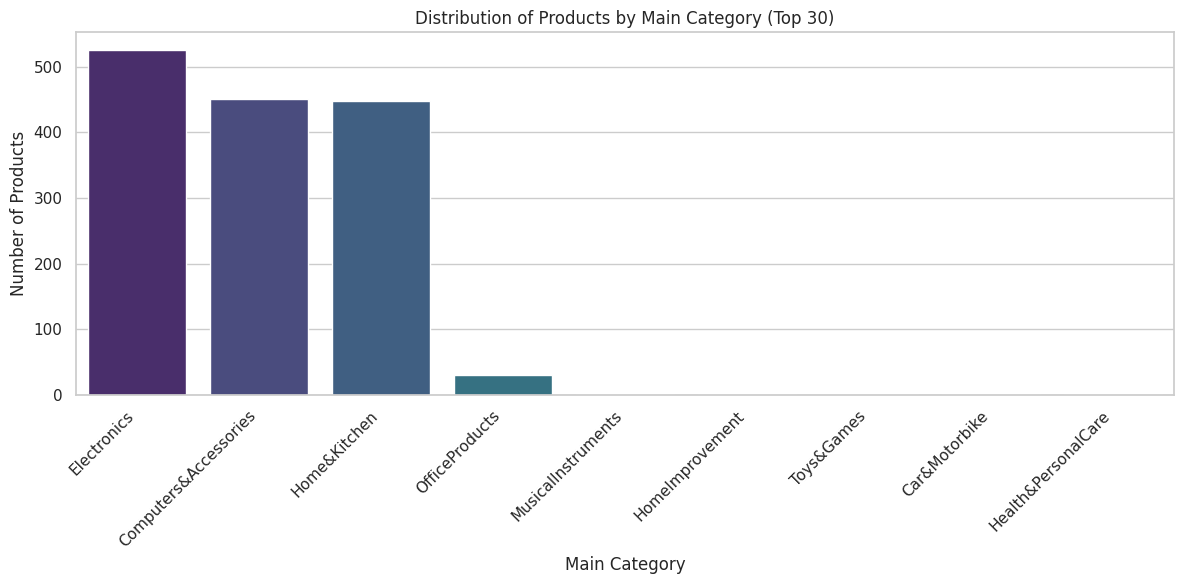

In [ ]:
main_category_counts = df['main_category'].value_counts()[:30]

plt.figure(figsize=(12, 6))
sns.barplot(x=main_category_counts.index, y=main_category_counts.values, palette='viridis')
plt.ylabel('Number of Products')
plt.xlabel('Main Category')
plt.title('Distribution of Products by Main Category (Top 30)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Product destribution by final category
* USB cables, smartwatches, smartphones, smart televisions, in-ear headphones, and remote controls are the most popular categories

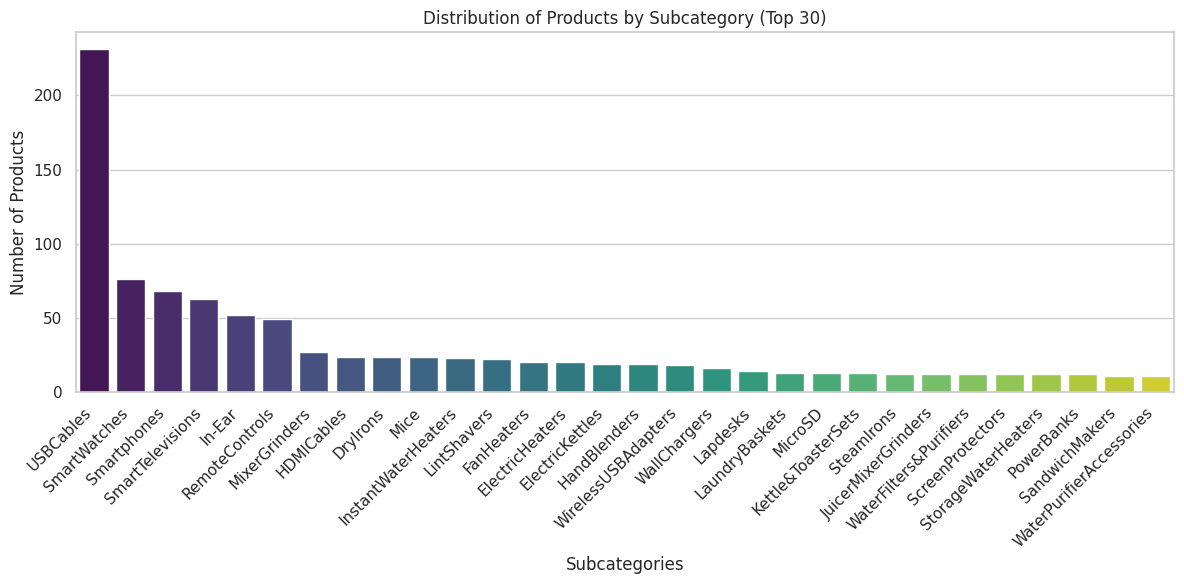

In [ ]:
sub_category_counts = df['sub_category'].value_counts()[:30]
plt.figure(figsize=(12, 6))
sns.barplot(x=sub_category_counts.index, y=sub_category_counts.values, palette='viridis')
plt.ylabel('Number of Products')
plt.xlabel('Subcategories')
plt.title('Distribution of Products by Subcategory (Top 30)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Price and Rating Relationship
* The plots shows a positive correlation (as price increases, so do ratings), it suggests that higher-priced products might be associated with higher customer satisfaction.
* High-priced products with low ratings could indicate poor customer satisfaction, suggesting a need to improve product quality, features, or customer service for these items.

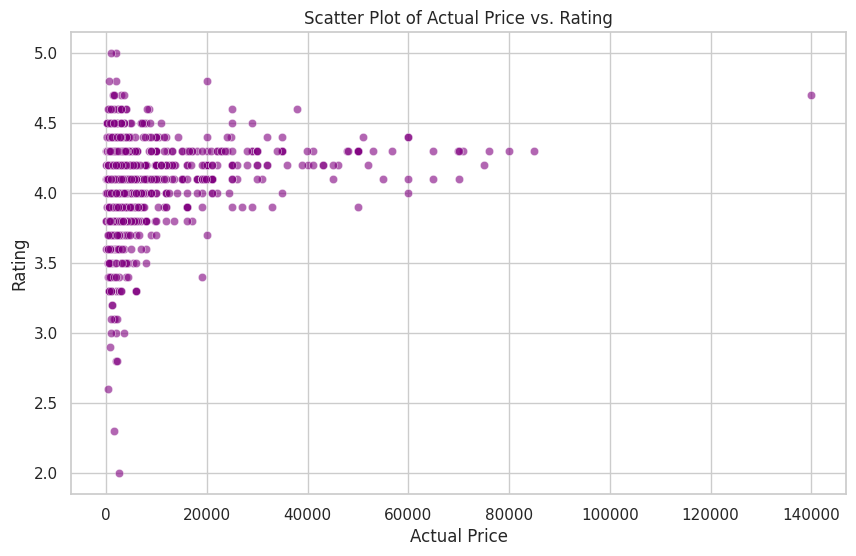

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['actual_price'], y=df['rating'], color='purple', alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Rating')
plt.title('Scatter Plot of Actual Price vs. Rating')
plt.show()

### Price Distribution
If the histogram is right-skewed (most products are priced lower, with a few higher-priced items), it suggests that most products are priced affordably, but there may be a few premium products.

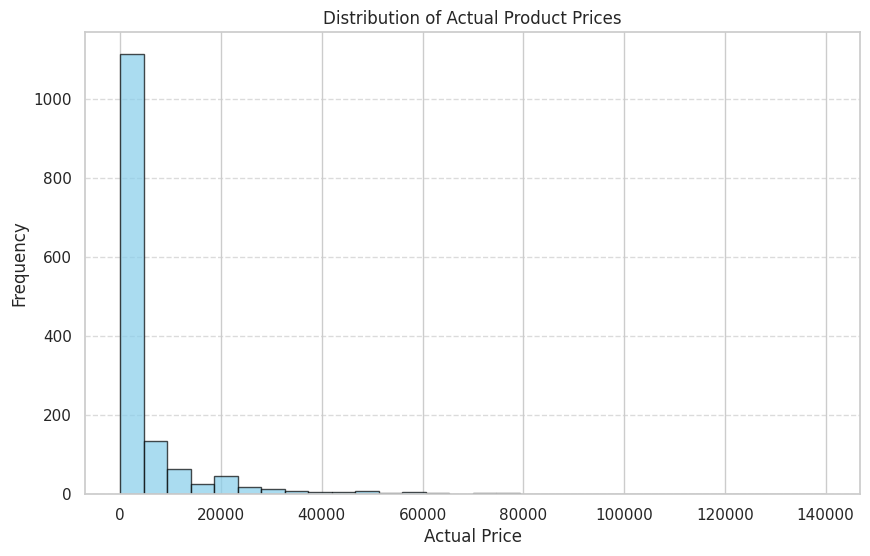

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['actual_price'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Actual Price')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Product Prices')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###  Rating Distribution
Majority of ratings are clustered around higher values (e.g., 4 and 4.5 stars), it indicates that customers are generally satisfied with the products.

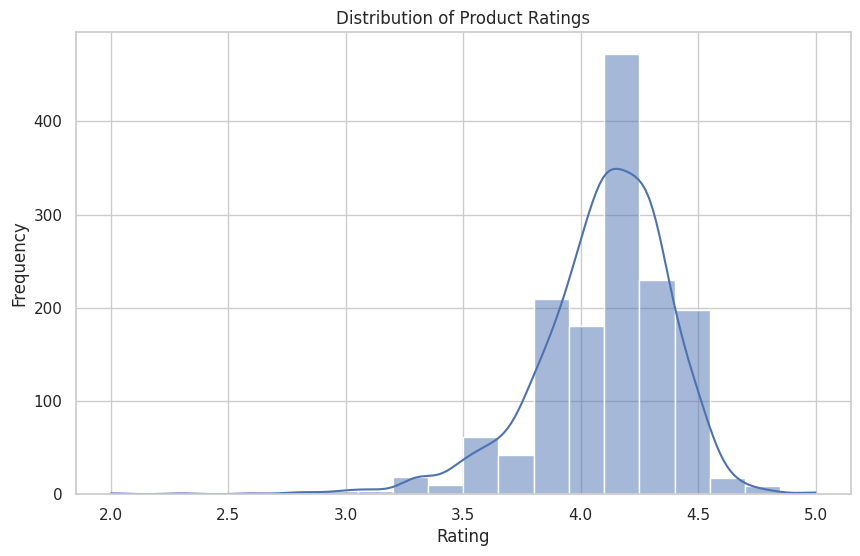

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Top 5 most discounted products

Top 5 Most Discounted Products:
695    rts [2 Pack] Mini USB C Type C Adapter Plug, T...
372    Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...
380    Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...
368    Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...
364    Fire-Boltt Ninja Call Pro Plus 1.83" Smart Wat...
Name: product_name, dtype: object


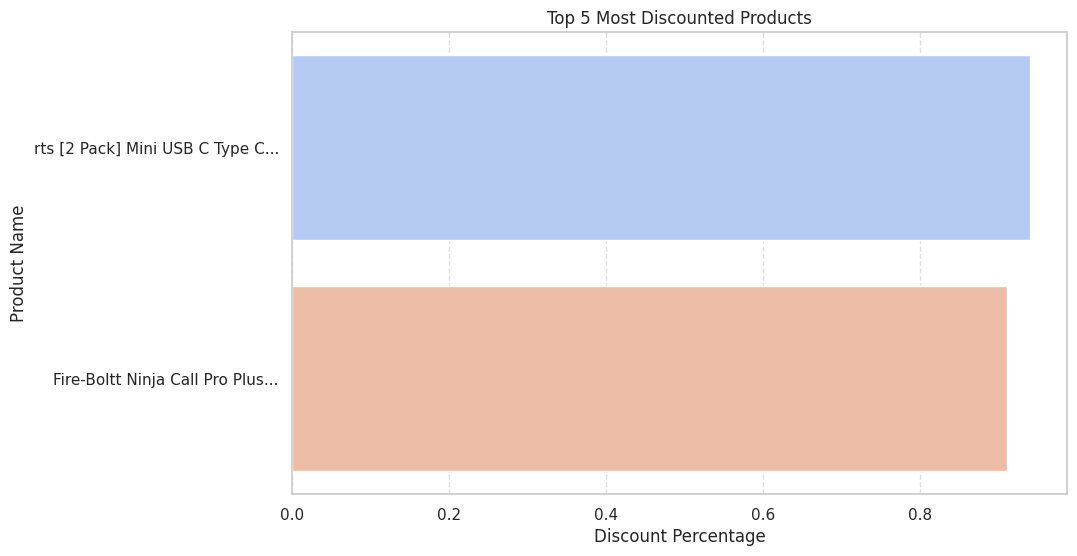

In [ ]:
top_5_discounted_products = df.sort_values(by='discount_percentage', ascending=False).head(5)

top_5_discounted_products['short_name'] = top_5_discounted_products['product_name'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)
print("Top 5 Most Discounted Products:")
print(top_5_discounted_products['product_name'].head(5))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_discounted_products,
    y='short_name',
    x='discount_percentage',
    palette='coolwarm'
)

plt.xlabel('Discount Percentage')
plt.ylabel('Product Name')
plt.title('Top 5 Most Discounted Products')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


### Rating Analysis
* Do longer reviews typically correspond to higher or lower ratings?
* Are there outliers with very long or very short reviews?

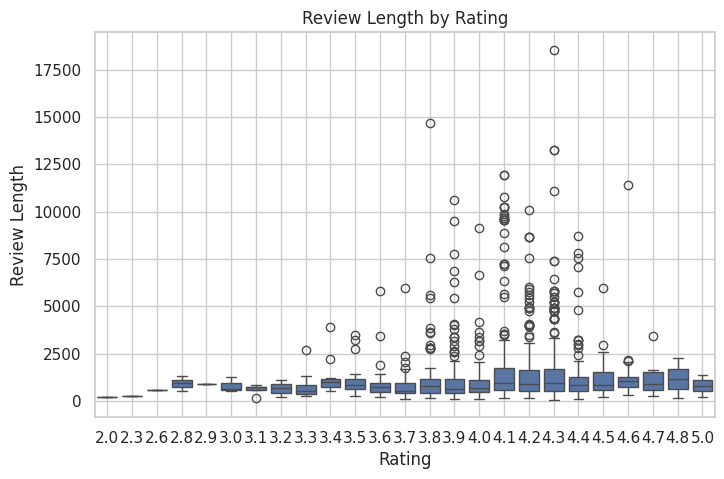

In [ ]:
# Calculate review length
df['review_length'] = df['review_content'].apply(lambda x: len(str(x)))

# Review length vs. rating
plt.figure(figsize=(8, 5))
sns.boxplot(x='rating', y='review_length', data=df)
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.grid(True)
plt.show()


## Sentiment Analysis on Customer Reviews

#### Reviews preprocessing
Before performing sentiment analysis, the data will be preprocess (cleaned and standardized), e.g.:
* Removing stopwords
* Tokenization
* Lemmatization
* Removing special characters, URLs, etc.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_review(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['review_content'].apply(preprocess_review)

#### VADER
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool designed specifically for social media, short texts, and product reviews. Unlike traditional sentiment analysis models, which are often based on complex machine learning algorithms or lexicons, VADER is a lexicon-based approach that incorporates sentiment intensity and the context of words.

In [ ]:
sia = SentimentIntensityAnalyzer()

def get_sentiment_vader(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

df['sentiment_score'] = df['cleaned_review'].apply(get_sentiment_vader)

def classify_sentiment_vader(score):
    sentiment_dict = {True: 'Positive', False: 'Negative'}
    return sentiment_dict.get(score > 0, 'Neutral')

df['sentiment'] = df['sentiment_score'].apply(classify_sentiment_vader)

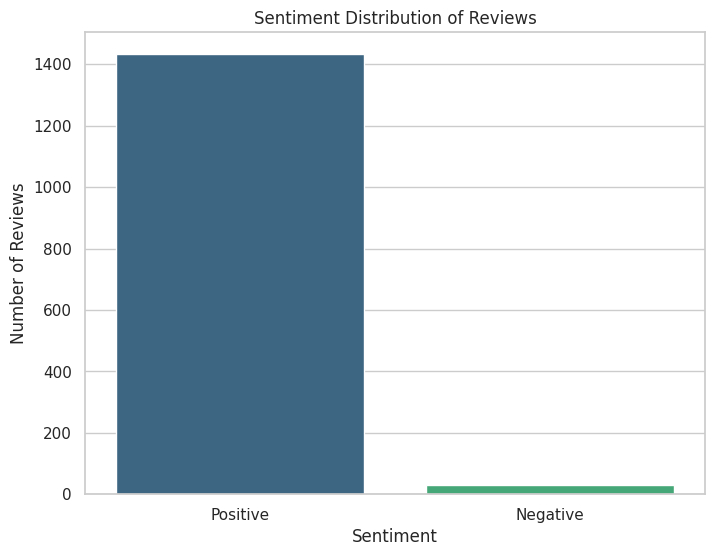

In [ ]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
df[df['sentiment_score'] < 0][['product_name', 'review_title', 'sentiment_score', 'sentiment']].head()

,product_name,review_title,sentiment_score,sentiment
22,Samsung 80 cm (32 Inches) Wondertainment Serie...,"Good,Sound is very low another brand comparing...",-0.5574,Negative
145,Airtel DigitalTV DTH Remote SD/HD/HD Recording...,"Good product,Not bad,WORKING WITH Airtel DTH,G...",-0.3182,Negative
152,Samsung 80 cm (32 inches) Wondertainment Serie...,"Good,Sound is very low another brand comparing...",-0.5574,Negative
155,7SEVEN® Compatible for Tata Sky Remote Origina...,do not buy,-0.7425,Negative
264,Realme Smart TV Stick 4K,"Great Product,Very good and working very nice,...",-0.3214,Negative


## Discounted Price Predition

### Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

### Prepring data
* **X**: Features used for prediction, including the actual_price, rating, and rating_count.
* **y**: The target variable, which is the discounted_price.
* scaling: mean=0, standard deviation of

In [ ]:
X = df[['actual_price', 'rating', 'rating_count']]
y = df['discounted_price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

* coef a are weights for each feature - shows how much a particular feature contributes to the predicted discounted_price
*

In [ ]:
print(model.coef_)
print(model.intercept_)

[6.69160356e+03 4.97349593e+00 7.75525049e+01]
3147.470839630256


### Model Evaluation

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 684.12
Mean Squared Error (MSE): 1913777.78
Root Mean Squared Error (RMSE): 1383.39
R-squared (R²): 0.93


* sns.scatterplot() plots the actual vs predicted values
* sns.regplot() adds a regression line that shows the trend of predicted values

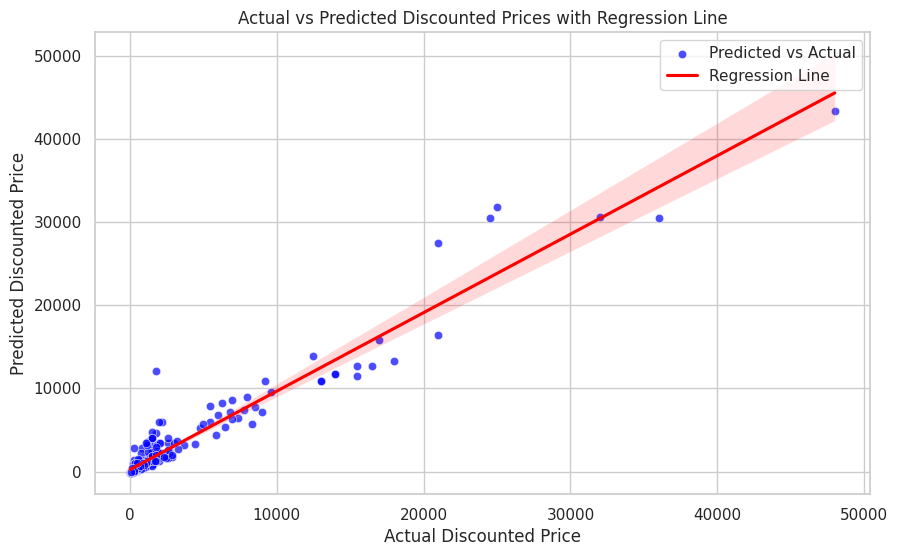

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')

sns.regplot(x=y_test, y=y_pred, scatter=False, color='red', label='Regression Line')
plt.xlabel('Actual Discounted Price')
plt.ylabel('Predicted Discounted Price')
plt.title('Actual vs Predicted Discounted Prices with Regression Line')
plt.grid(True)
plt.legend()
plt.show()

* plot shows the difference between the actual and predicted values (y_test - y_pred)
* model has residuals that are randomly distributed around zero

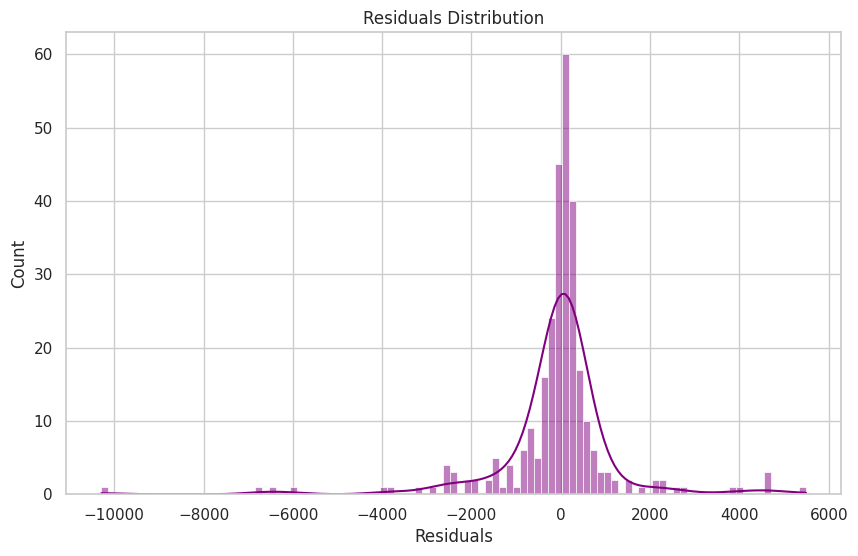

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.grid(True)
plt.show()

### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
X = df[['actual_price', 'rating', 'rating_count']]
y = df['discounted_price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Dense(64, activation='leaky_relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='leaky_relu'),
    Dense(16, activation='leaky_relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 49112028.0000 - mae: 2989.4375 - val_loss: 72996616.0000 - val_mae: 3709.5588
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 61306964.0000 - mae: 3365.3108 - val_loss: 72970920.0000 - val_mae: 3708.4563
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 54314456.0000 - mae: 3018.9983 - val_loss: 72900304.0000 - val_mae: 3705.3970
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 74518504.0000 - mae: 3577.0210 - val_loss: 72724768.0000 - val_mae: 3697.3630
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 79808928.0000 - mae: 3466.8599 - val_loss: 72352320.0000 - val_mae: 3679.8079
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40967336.0000 - mae: 2673.2866 - val_loss: 71639952.0000 - val_mae: 3645.2224
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59742648.0000 - mae: 3168.2324 - val_loss: 70417248.0000 - val_mae: 3584.7419
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred = model.predict(X_test)

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
      Actual    Predicted
894   1199.0  1146.860229
1108  1099.0   953.694580
415    599.0  1074.925049
524     99.0   239.272308
1038  1290.0  1086.210693


In [ ]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.2f}")
print(f"Test Mean Absolute Error (MAE): {test_mae:.2f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2158558.2500 - mae: 697.4241 
Test Loss (MSE): 1870265.50
Test Mean Absolute Error (MAE): 653.66
Root Mean Squared Error (RMSE): 1367.58
R² Score: 0.94


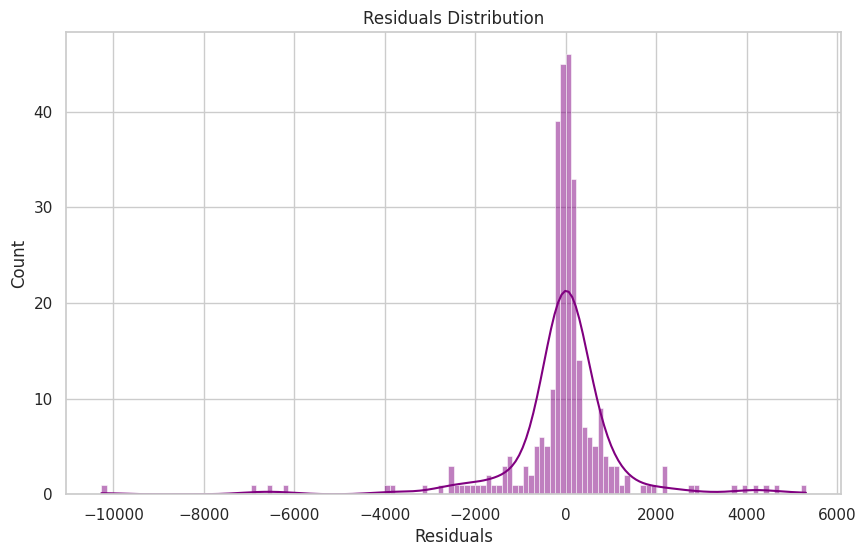

In [ ]:
y_pred = y_pred.flatten()
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.grid(True)
plt.show()

## Customer Recommendations

#### Converts user_id`s into numeric values

In [ ]:
le = LabelEncoder()
df['user_id_encoded'] = le.fit_transform(df['user_id'])

#### Frequency table showing how many times each user (represented by their encoded user ID) has interacted with products in the dataset

In [ ]:
freq_table = pd.DataFrame({'User ID': df['user_id_encoded'].value_counts().index, 'Frequency': df['user_id_encoded'].value_counts().values})


In [ ]:
freq_table.head()

,User ID,Frequency
0,1045,10
1,622,8
2,673,8
3,253,7
4,87,7


#### Function

* TfidfVectorizer is used to transform product descriptions into numerical vectors. This converts the text data into a format suitable for calculating similarities between products
* cosine_similarity computes the similarity between product descriptions. It compares the products that the user has purchased to all other products in the dataset, based on their descriptions

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Precompute the TF-IDF matrix and cache it for reuse
def get_tfidf_matrix(df):
    tfidf = TfidfVectorizer(stop_words='english')
    df['about_product'] = df['about_product'].fillna('')
    return tfidf.fit_transform(df['about_product'])

# Function to recommend products based on user purchase history and content similarity
def recommend_products(df, user_id_encoded, tfidf_matrix=None):
    if tfidf_matrix is None:
        tfidf_matrix = get_tfidf_matrix(df)

    user_history = df[df['user_id_encoded'] == user_id_encoded]

    if user_history.empty:
        print("No purchase history found.")
        return None

    indices = user_history.index.tolist()

    cosine_sim_user = cosine_similarity(tfidf_matrix[indices], tfidf_matrix)

    products = df.iloc[indices]['product_name']
    similarity_scores = []

    for i in range(len(indices)):
        for j in range(len(df)):
            if j not in indices:  # Exclude products the user has already purchased
                similarity_scores.append((df.iloc[j]['product_name'], cosine_sim_user[i, j]))

    # Sort products by similarity score in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Select top 5 recommended products
    top_products = [x[0] for x in similarity_scores[:5]]
    scores = [x[1] for x in similarity_scores[:5]]

    # Create results DataFrame with recommendations
    results_df = pd.DataFrame({
        'user_id_encoded': [user_id_encoded] * 5,
        'recommended_product': top_products,
        'score': scores
    })

    return results_df

In [ ]:
matrix = get_tfidf_matrix(df)

In [ ]:
recommend_products(df, 253, matrix)

,user_id_encoded,recommended_product,score
0,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,1.0
1,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,1.0
2,253,boAt Rugged v3 Extra Tough Unbreakable Braided...,1.0
3,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,1.0
4,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,1.0


In [ ]:
df[df['user_id_encoded'] == 253][['user_id_encoded', 'product_name', 'sub_category']]

,user_id_encoded,product_name,sub_category
3,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,USBCables
11,253,boAt Rugged v3 Extra Tough Unbreakable Braided...,USBCables
92,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,USBCables
258,253,boAt Rugged V3 Braided Micro USB Cable (Pearl ...,USBCables
392,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,USBCables
443,253,boAt Rugged v3 Extra Tough Unbreakable Braided...,USBCables
628,253,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,USBCables
